# Predictive Coding

In [1]:
import numpy as np
import nengo
from copy import deepcopy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

from training import *
from activations import *
from learning_rates import *
from baseline import BaselineClassifier
from pc_network import *

# Classification

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [3]:
x_data, y_data = load_iris(return_X_y=True)
y_data = y_data.reshape((y_data.shape[0],1))

In [4]:
enc = OneHotEncoder()
y_data = enc.fit_transform(y_data).toarray()

In [5]:
#define data
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=True)

In [11]:
with nengo.Network() as net:
    tau = 0.01
    #============== Run in Direct mode =======================
    net.config[nengo.Ensemble].neuron_type = nengo.Direct()
    #=========================================================
    net.config[nengo.Connection].synapse = tau
    net.config[nengo.Probe].synapse = 0
    
    epochs = 5
    stab_time = 0
    learn_time = 0.2
    shuffle = True
    inf_time = 1
    #define data
    x_input, y_input, learn_until = create_learning_inputs(x_train, y_train, epochs, stab_time, learn_time, shuffle)
    #add testing phase
    add_inference_inputs(x_test, y_test, x_input, y_input, inf_time=inf_time, learn_until=learn_until)

    stim = nengo.Node(nengo.processes.Piecewise(x_input))   # sensory (bottom layer)
    pred = nengo.Node(nengo.processes.Piecewise(y_input))  # percept (top layer)
    
    #define learning rate
    #tau_learn = ConstRate(0.1)
    tau_learn = PowerRate(0.1, 10, 0.8, learn_until)
    
    # PC layers
    PC_net = PCNetwork(n_nodes=[4, 25, 25, 3], tau_learn=tau_learn, symmetric=True, activation=Tanh(), learn_until=learn_until)
    PC_net.connect_input(stim=stim)
    PC_net.connect_output(pred)

    # Set up a bunch of probes (so we can plot stuff later)
    p_stim = nengo.Probe(stim)
    p_pc1v = nengo.Probe(PC_net.layers[0].v.output)
    p_pc1e = nengo.Probe(PC_net.layers[0].e.output)
    p_pc_end_v = nengo.Probe(PC_net.layers[-1].v.output)
    p_pc_end_e = nengo.Probe(PC_net.layers[-1].e.output)
    p_pred = nengo.Probe(pred)

    val_probes, err_probes = PC_net.get_probes()

dt = 0.0001
sim = nengo.Simulator(net, dt=dt)

Build finished in 0:00:01.                                                      


In [12]:
train_network(sim, PC_net, stab_time, learn_time, learn_until)

Simulation finished in 0:09:37.                                                 


In [13]:
preds = test_network(sim, PC_net, y_test.shape[0], inf_time, val_probes[-1])

Simulation finished in 0:00:05.                                                 
Simulation finished in 0:00:05.                                                 
Simulation finished in 0:00:05.                                                 
Simulation finished in 0:00:05.                                                 
Simulation finished in 0:00:05.                                                 
Simulation finished in 0:00:05.                                                 
Simulation finished in 0:00:05.                                                 
Simulation finished in 0:00:05.                                                 
Simulation finished in 0:00:05.                                                 
Simulation finished in 0:00:05.                                                 
Simulation finished in 0:00:05.                                                 
Simulation finished in 0:00:05.                                                 
Simulation finished in 0:00:

Architecture:
- Layers: [4, 25, 25, 3]
- Activations: ['Tanh', 'Tanh', 'Tanh']
- Symmetric: True
- Learning rate: ['<learning_rates.PowerRate object at 0x000001B0A160D0D0>', '<learning_rates.PowerRate object at 0x000001B0A160D0D0>', '<learning_rates.PowerRate object at 0x000001B0A160D0D0>']
Trained the network for 5 epochs (shuffled=True), holding each sample for 0.2 s. Inference time was 1 s.
Testing:
The number of each class in the test set: [ 9. 11. 10.]
The number of each class predicted when testing: [ 9.  3. 18.]
Test accuracy: 0.7333333333333333
We learn until t=120.00000000000117


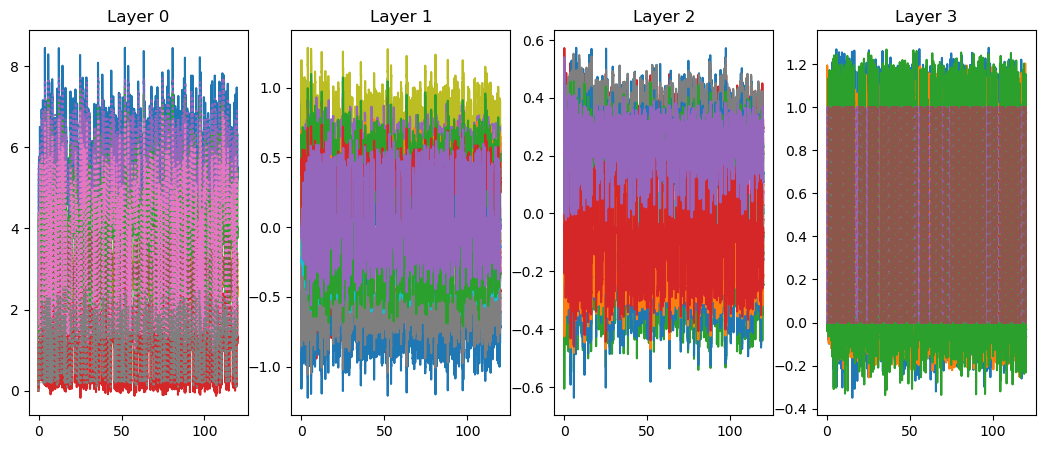

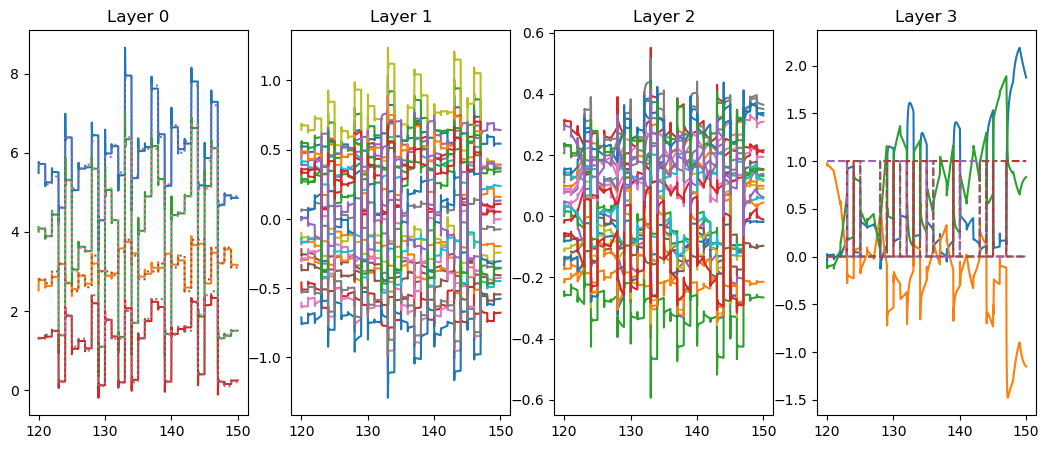

In [14]:
pred_class = np.zeros_like(preds)
indices = np.argmax(preds, axis=1)
i = 0
for idx in indices:
    pred_class[i,idx] = 1
    i += 1

acc = np.sum(pred_class*y_test)/y_test.shape[0]

### Print summary of the network learning ###
print("Architecture:")
print(f"- Layers: {[layer.n_nodes for layer in PC_net.layers]}")
print(f"- Activations: {[str(entry) for entry in PC_net.activation]}")
print(f"- Symmetric: {PC_net.symmetric}")
print(f"- Learning rate: {[str(entry) for entry in PC_net.tau_learn]}")
print(f"Trained the network for {epochs} epochs (shuffled={shuffle}), holding each sample for {learn_time} s. Inference time was {inf_time} s.")

print("Testing:")
print(f"The number of each class in the test set: {np.sum(y_test, axis=0)}")
print(f"The number of each class predicted when testing: {np.sum(pred_class, axis=0)}")

print(f"Test accuracy: {acc}")

### Plotting ###

n_layers = len(PC_net.layers)

fig, ax = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 4000]
idx = [4000, 16000]
#idx = [18000, 20000]
idx = [0, int(learn_until/dt)]
#idx = [115000, 120000]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax[k].set_title(f'Layer {k}');

ax[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':', label="Stim");  
ax[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--', label="Pred");


print(f"We learn until t={learn_until}")

n_layers = len(PC_net.layers)

fig2, ax2 = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 2000]
idx = [1200000, 1216000]
idx = [int(learn_until/dt), -1] #plot only learning segments
#idx = [0, len(sim.trange())]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax2[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax2[k].set_title(f'Layer {k}');


ax2[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':');    
ax2[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--');

In [10]:
#what is the baseline test accuracy of classifiers?

base = BaselineClassifier()
base.fit(x_train, y_train)

random_acc, uniform_acc, zero_acc = base.empirical_accuracy(x_test, y_test, N=1000)

print(f"Random accuracy = {random_acc}")
print(f"Uniform accuracy = {uniform_acc}")
print(f"Zero rate accuracy = {zero_acc}")

Random accuracy = 0.3326000000000007
Uniform accuracy = 0.3380333333333336
Zero rate accuracy = 0.30000000000000565


# Try to Learn Using Pytorch and Copy the Weights

In [ ]:
class TestNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(4, 20, bias=False),
            nn.Tanh(),
            nn.Linear(20, 3, bias=False),
            nn.Tanh()
        )
    
    def forward(self, X):
        return self.layers(X)
    
    def train_model(self, dl, optim, loss_func, epochs):
        self.train()
        losses = []
        for e in range(epochs):
            for batch_num, (X, Y) in enumerate(dl):
                out = self(X)
                loss = loss_func(out, Y)

                loss.backward()
                optim.step()
                optim.zero_grad()
            
            losses.append(loss.item())
        return losses

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = self.X[idx,:]
        y = self.Y[idx,:]
        return x, y

In [ ]:
#X = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
#Y = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
ds = CustomDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
dl = torch.utils.data.DataLoader(ds, batch_size=10, shuffle=True)

In [ ]:
net = TestNN()
loss = nn.CrossEntropyLoss(reduction="mean")
optim = torch.optim.SGD(net.parameters(), lr=1e-3)
epochs = 1000

In [ ]:
losses = net.train_model(dl, optim, loss, epochs)

In [ ]:
plt.figure()
plt.plot(losses)
plt.ylabel("Cross-Entropy Loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
# train
with torch.no_grad():
    preds = net(torch.from_numpy(x_train).float()).numpy()
    acc = np.sum((np.argmax(preds, axis=1) == np.argmax(y_train, axis=1)))
print(f"Train accuracy: {acc/x_train.shape[0]}")

In [ ]:
# test
with torch.no_grad():
    preds = net(torch.from_numpy(x_test).float()).numpy()
    acc = np.sum((np.argmax(preds, axis=1) == np.argmax(y_test, axis=1)))
print(f"Test accuracy: {acc/x_test.shape[0]}")

In [ ]:
W1 = net.layers[0].weight.detach().numpy()
W2 = net.layers[2].weight.detach().numpy()
#print(W1)
#print(W2)

In [ ]:
# Using PCNetwork class
n = 1
with nengo.Network() as net:
    tau = 0.01
    #============== Run in Direct mode =======================
    net.config[nengo.Ensemble].neuron_type = nengo.Direct()
    #=========================================================
    net.config[nengo.Connection].synapse = tau
    net.config[nengo.Probe].synapse = 0
    
    epochs = 0 #no training in this case
    stab_time = 0
    learn_time = 0.05
    shuffle = True
    inf_time = 0.2
    #define data
    x_input, y_input, learn_until = create_learning_inputs(x_train, y_train, epochs, stab_time, learn_time, shuffle)
    #add testing phase
    num_preds = add_inference_inputs(x_test, y_test, x_input, y_input, inf_time=inf_time, learn_until=learn_until)
    
    stim = nengo.Node(nengo.processes.Piecewise(x_input))   # sensory (bottom layer)
    pred = nengo.Node(nengo.processes.Piecewise(y_input))  # percept (top layer)
    
    # PC layers
    PC_net = PCNetwork(n_nodes=[4, 20, 3], tau_learn=0.1, symmetric=True, activation=Tanh, learn_until=learn_until)
    
    #copy connection weights
    PC_net.connections[0].W = W1.T
    PC_net.connections[1].W = W2.T
    PC_net.connections[0].M = W1
    PC_net.connections[1].M = W2
    
    PC_net.connect_input(stim=stim)
    PC_net.connect_output(pred)
    '''
     [     /-->         ] -W-> [      /-->       ] -W-> [      /-->       ]      [      ]
     [ stim     stim_err]      [ pc1.v     pc1.e ]      [ pc2.v     pc2.e ]      [ pred ]
     [                  ] <-M- [       <--/      ] <-M- [       <--/      ] <-M- [      ]
    '''
    
 
    # Set up a bunch of probes (so we can plot stuff later)
    p_stim = nengo.Probe(stim)
    p_pc1v = nengo.Probe(PC_net.layers[0].v.output)
    p_pc1e = nengo.Probe(PC_net.layers[0].e.output)
    p_pc_end_v = nengo.Probe(PC_net.layers[-1].v.output)
    p_pc_end_e = nengo.Probe(PC_net.layers[-1].e.output)
    p_pred = nengo.Probe(pred)

    val_probes, err_probes = PC_net.get_probes()

In [ ]:
sim = nengo.Simulator(net)

In [ ]:
if not epochs == 0: #with no epochs we don't train at all
    train_network(sim, PC_net, stab_time, learn_time, learn_until)

In [ ]:
preds = test_network(sim, PC_net, num_preds, inf_time, val_probes[-1])

pred_class = np.zeros_like(preds)
indices = np.argmax(preds, axis=1)
i = 0
for idx in indices:
    pred_class[i,idx] = 1
    i += 1

acc = np.sum(pred_class*y_test)/y_test.shape[0]

In [ ]:
### Print summary of the network learning ###
print("Architecture:")
print(f"- Layers: {[layer.n_nodes for layer in PC_net.layers]}")
print(f"- Activations: {PC_net.activation}")
print(f"- Symmetric: {PC_net.symmetric}")
print(f"- Learning rate: {PC_net.tau_learn}")
print(f"Trained the network for {epochs} epochs (shuffled={shuffle}), holding each sample for {learn_time} s. Inference time was {inf_time} s.")

print("Testing:")
print(f"The number of each class in the test set: {np.sum(y_test, axis=0)}")
print(f"The number of each class predicted when testing: {np.sum(pred_class, axis=0)}")

print(f"Test accuracy: {acc}")

### Plotting ###

n_layers = len(PC_net.layers)

fig, ax = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 4000]
idx = [7000, 10000]
#idx = [18000, 20000]
idx = [0, len(sim.trange())]
#idx = [115000, 120000]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax[k].set_title(f'Layer {k}');

ax[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':', label="Stim");  
ax[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--', label="Pred");

"""
print(f"We learn until t={learn_until}")

n_layers = len(PC_net.layers)

fig2, ax2 = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 2000]
idx = [7000, 7800]
idx = [int(learn_until/0.001), -1] #plot only learning segments
#idx = [0, len(sim.trange())]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax2[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax2[k].set_title(f'Layer {k}');


ax2[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':');    
ax2[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--');
"""